<a href="https://colab.research.google.com/github/mb8655/Python/blob/main/Advanced_data_manipulation_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pandas beyond SQL
##advanced data manipulation techniques

In [3]:
''' setup and prelimnaries '''

!pip install -U -q PyMySQL sqlalchemy

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#render our plots with high resolution
%config InlineBackend.figure_format = 'retina'

#make the graphs a bit bigger
matplotlib.style.use(["seaborn-v0_8-talk", "seaborn-v0_8-ticks", "seaborn-v0_8-whitegrid"])

#setting the default figure size for pandas plots
pd.options.plotting.backend = "matplotlib"
plt.rcParams['figure.figsize'] = (10, 6)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.3 MB/s eta 0:00:00


In [4]:
''' MySQL setup '''

import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2025',
    db = 'doh_restaurants',
    encoding = 'utf8mb4')

engine = create_engine(conn_string)

#query for restaurants in the DOH database
sql = '''
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO,
          R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE, R.NTA
		FROM doh_restaurants.restaurants R
'''
with engine.connect() as conn:
    restaurants = pd.read_sql(text(sql), conn)

#query for inspections
sql = '''
	SELECT R.CAMIS, R.DBA, R.ZIPCODE, R.BORO, R.CUISINE_DESCRIPTION, R.NTA,
				 I.INSPECTION_DATE, I.INSPECTION_ID,
				 I.INSPECTION_TYPE, I.SCORE, I.GRADE
	FROM restaurants R
		JOIN inspections I ON I.CAMIS = R.CAMIS
'''
with engine.connect() as conn:
    inspections = pd.read_sql(text(sql), conn)







In [5]:
print(restaurants.head())
print(inspections.head())

      CAMIS                             DBA BUILDING              STREET  \
0  30075445           MORRIS PARK BAKE SHOP     1007  MORRIS PARK AVENUE   
1  30112340                         WENDY'S      469     FLATBUSH AVENUE   
2  30191841  DJ REYNOLDS PUB AND RESTAURANT      351    WEST   57 STREET   
3  40356018                RIVIERA CATERERS     2780    STILLWELL AVENUE   
4  40356483              WILKEN'S FINE FOOD     7114            AVENUE U   

  ZIPCODE       BORO       CUISINE_DESCRIPTION  LATITUDE  LONGITUDE   NTA  
0   10462      Bronx  Bakery Products/Desserts   40.8482   -73.8560  BX37  
1   11225   Brooklyn                Hamburgers   40.6627   -73.9621  BK60  
2   10019  Manhattan                     Irish   40.7673   -73.9843  MN15  
3   11224   Brooklyn                  American   40.5799   -73.9821  BK21  
4   11234   Brooklyn                Sandwiches   40.6201   -73.9070  BK45  
      CAMIS                    DBA ZIPCODE      BORO  \
0  30075445  MORRIS PARK BAKE S

##Simple pivot tables

In [6]:
res_per_boro = pd.pivot_table(
    data=restaurants,
    aggfunc='count',    #we count...(the aggregation funtion)
    values='CAMIS',    # the different CAMIS numbers (what we aggregate)
    index='BORO'      # per BORO (and how we specify the groups, ie the variable that we use for dividing the data)
)

# view full pivot table
print(res_per_boro)

               CAMIS
BORO                
Bronx           1818
Brooklyn        5156
Manhattan       7579
Queens          4438
Staten Island    751


In [7]:
# average inspection score by cuisine

Score_per_cuisine = pd.pivot_table(
    data=inspections,
    index='CUISINE_DESCRIPTION',  # specifies the rows
    values='SCORE',    # specifies the content of the cells
    aggfunc='mean'    # we calculate the average/mean score
)

# Pivot table
Score_per_cuisine

,SCORE
CUISINE_DESCRIPTION,
Afghan,14.440000
African,26.276119
American,14.864405
Asian/Asian Fusion,19.804598
Australian,15.927273
...,...
Tex-Mex,13.247268
Thai,19.934236
Turkish,19.000000


<Axes: ylabel='CUISINE_DESCRIPTION'>

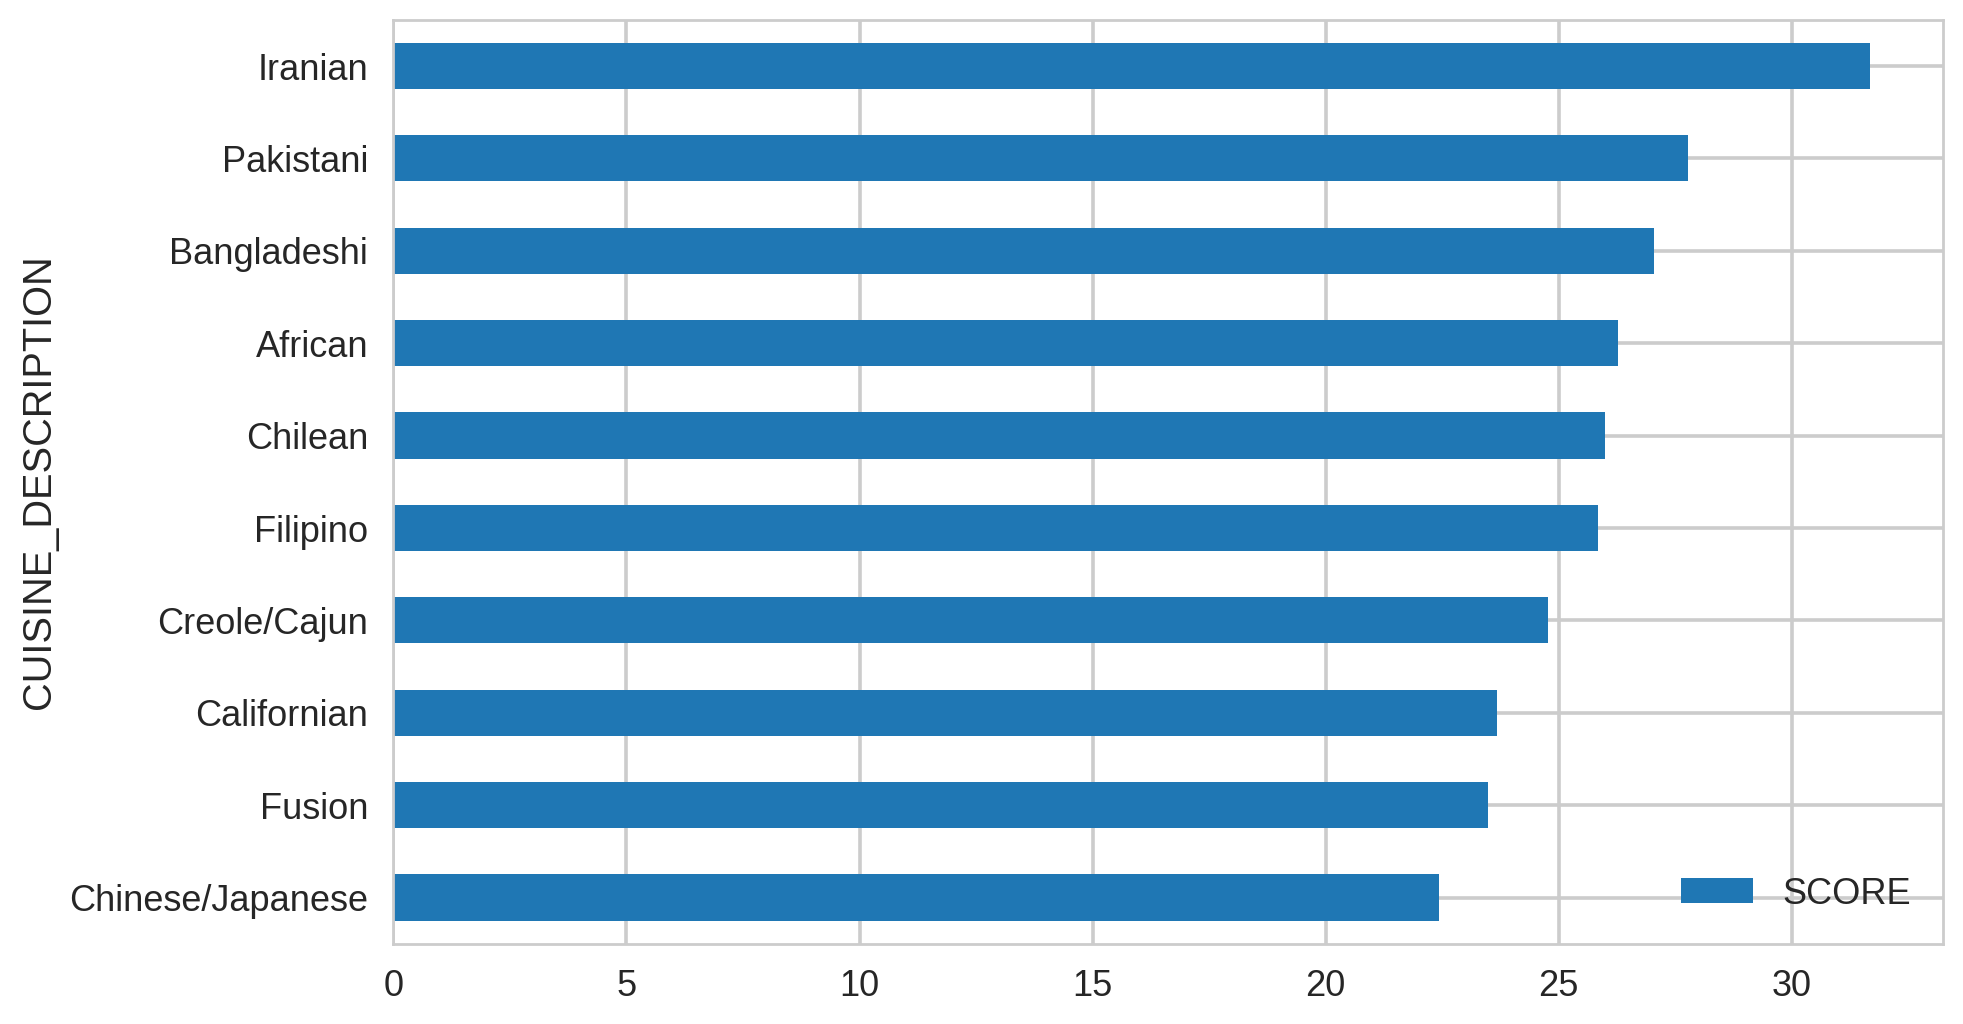

In [8]:
# top 10 highest scoring cuisines
(    Score_per_cuisine
    .sort_values('SCORE') # sort in asceding order of score
    .tail(10) # take the 10 entries in the largest values (at the botoom)
    .plot(kind='barh') # create a bar plot
)

In [9]:
score_per_boro = pd.pivot_table(
    data=inspections,
    index="NTA",  # specifies the rows
    values="SCORE",  # specifies the content of the cells
    aggfunc="mean",  # we calculate the average/mean score
)

score_per_boro

,SCORE
NTA,
BK09,17.147619
BK17,15.511628
BK19,18.317308
BK21,13.815126
BK23,14.375000
...,...
SI36,18.319588
SI37,16.800000
SI45,15.187919


<Axes: ylabel='NTA'>

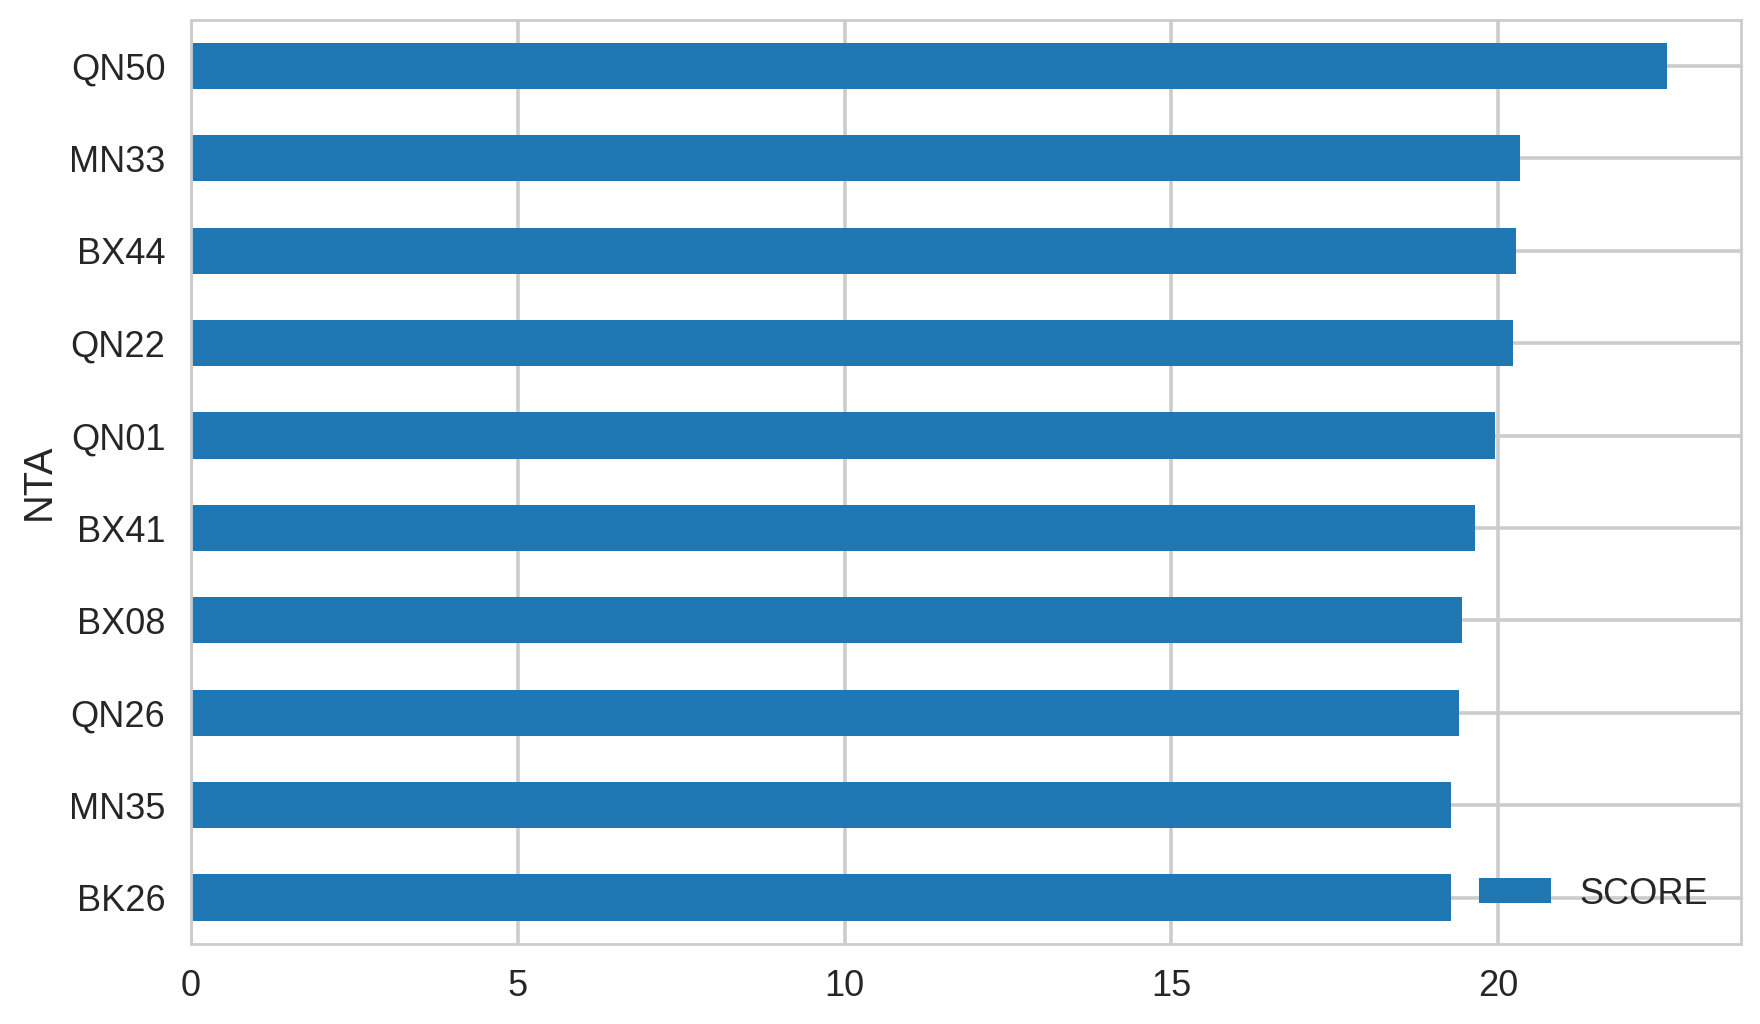

In [10]:
# top 10 highest scoring nta
(    score_per_boro
    .sort_values('SCORE') # sort in asceding order of score
    .tail(10) # take the 10 entries in the largest values (at the botoom)
    .plot(kind='barh') # create a bar plot
)

In [11]:
# Count the number of CAMIS values that appear on each date
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # specifies the rows
    values="CAMIS",  # specifies the content of the cells
    aggfunc="count",  # we ask to count how many different CAMIS values we see
)

pivot

,CAMIS
INSPECTION_DATE,
2015-10-14,1
2015-11-19,1
2015-11-20,1
2015-12-01,1
2015-12-12,1
...,...
2024-05-20,107
2024-05-21,86
2024-05-22,99


<Axes: xlabel='INSPECTION_DATE'>

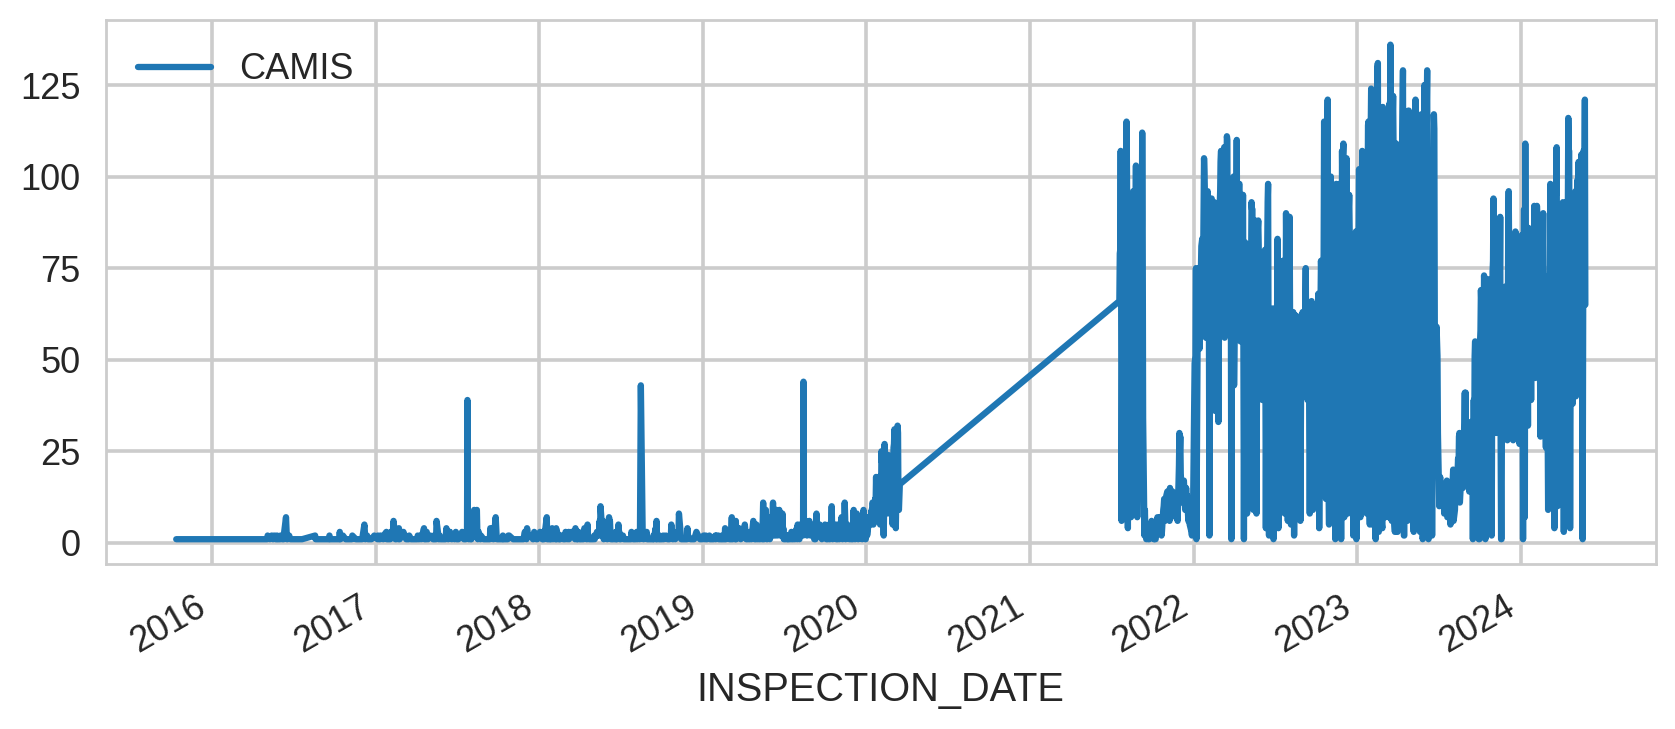

In [12]:
#plot
pivot.plot(kind = 'line', y = 'CAMIS', figsize=(10, 4))


<Axes: xlabel='INSPECTION_DATE'>

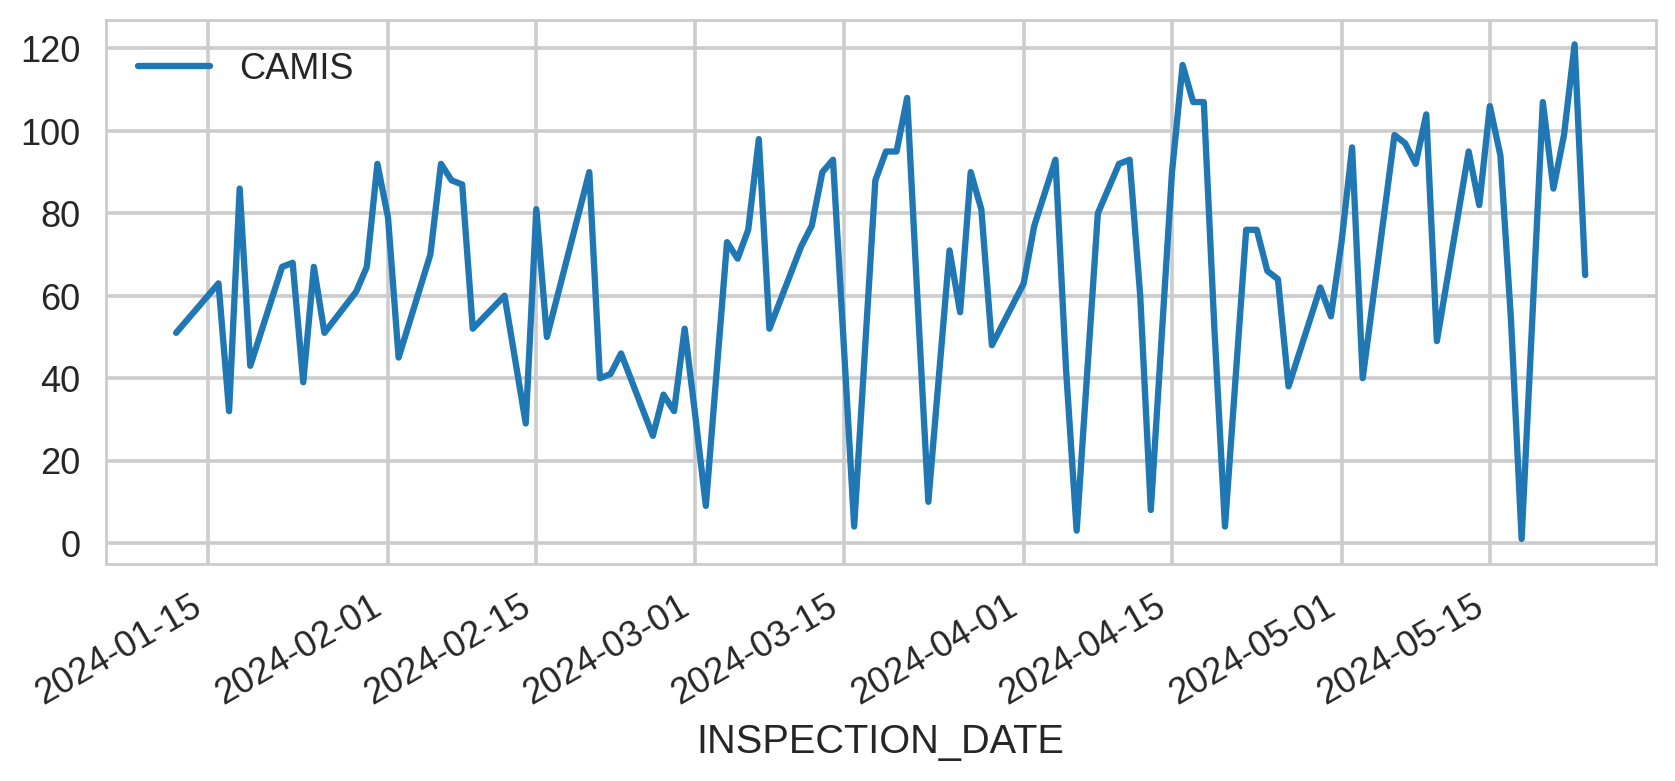

In [13]:
#plot last 100 entries
pivot.tail(100).plot(kind = 'line', y = 'CAMIS', figsize=(10, 4))

<Axes: xlabel='INSPECTION_DATE'>

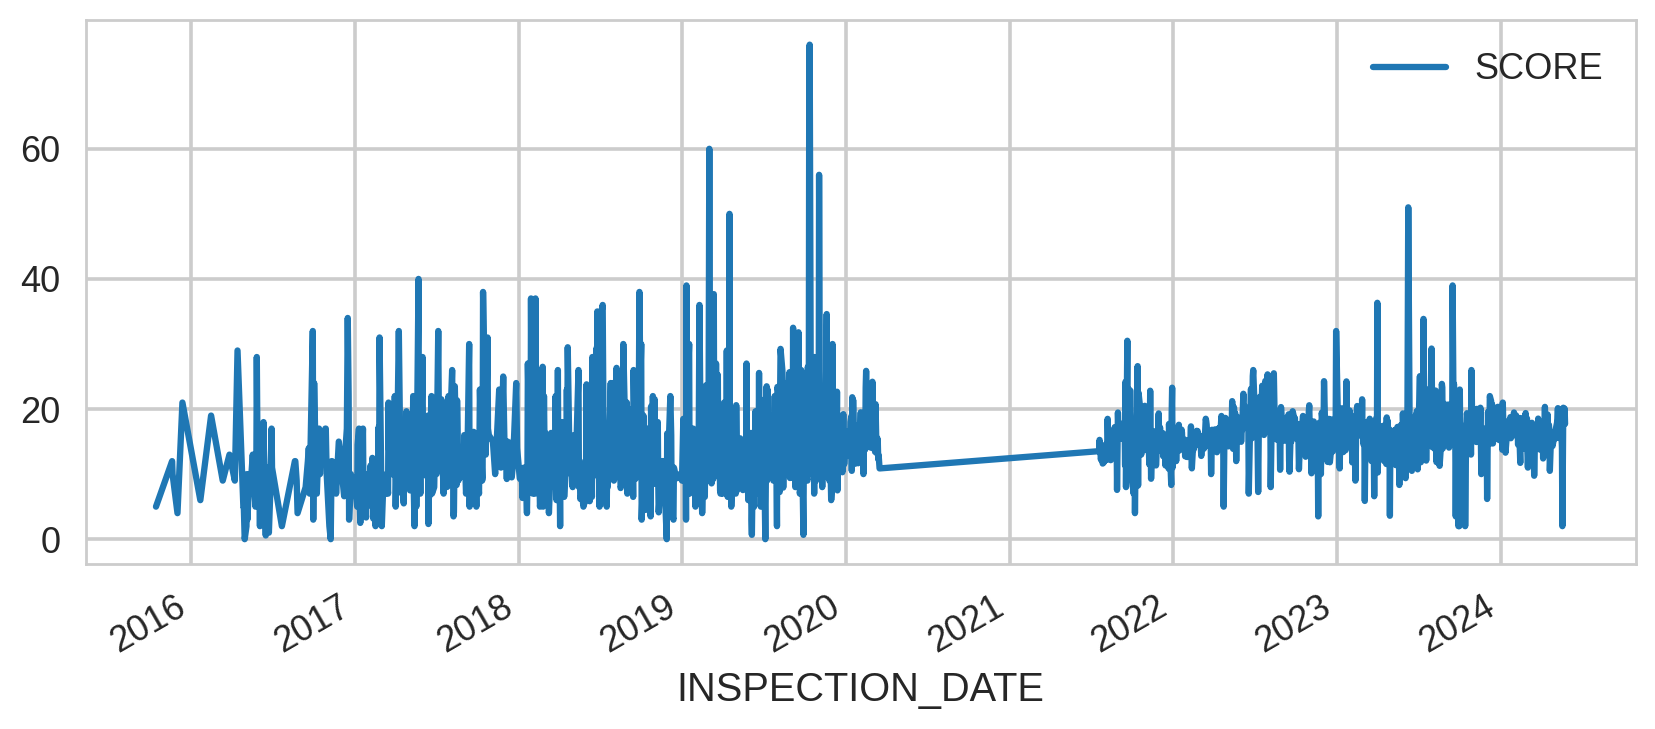

In [14]:
'''compute the average score assigned by the inspectors.'''


pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # specifies the rows
    values="SCORE",  # specifies the content of the cells
    aggfunc="mean",  # compute the average SCORE
)

pivot.plot(figsize=(10, 4))

##Changing date granularity
We can also use the resample command to change the frequency from one day, to, say, 7 days. Then we can compute, say, the average (mean()) for these days, or the total number (sum()) of inspections.

In [15]:
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # specifies the rows
    values="CAMIS",  # specifies the content of the cells
    aggfunc="count",  # we ask to count how many different CAMIS values we see
)

pivot.resample("1W").sum()

,CAMIS
INSPECTION_DATE,
2015-10-18,1
2015-10-25,0
2015-11-01,0
2015-11-08,0
2015-11-15,0
...,...
2024-04-28,320
2024-05-05,326
2024-05-12,441


<Axes: xlabel='INSPECTION_DATE'>

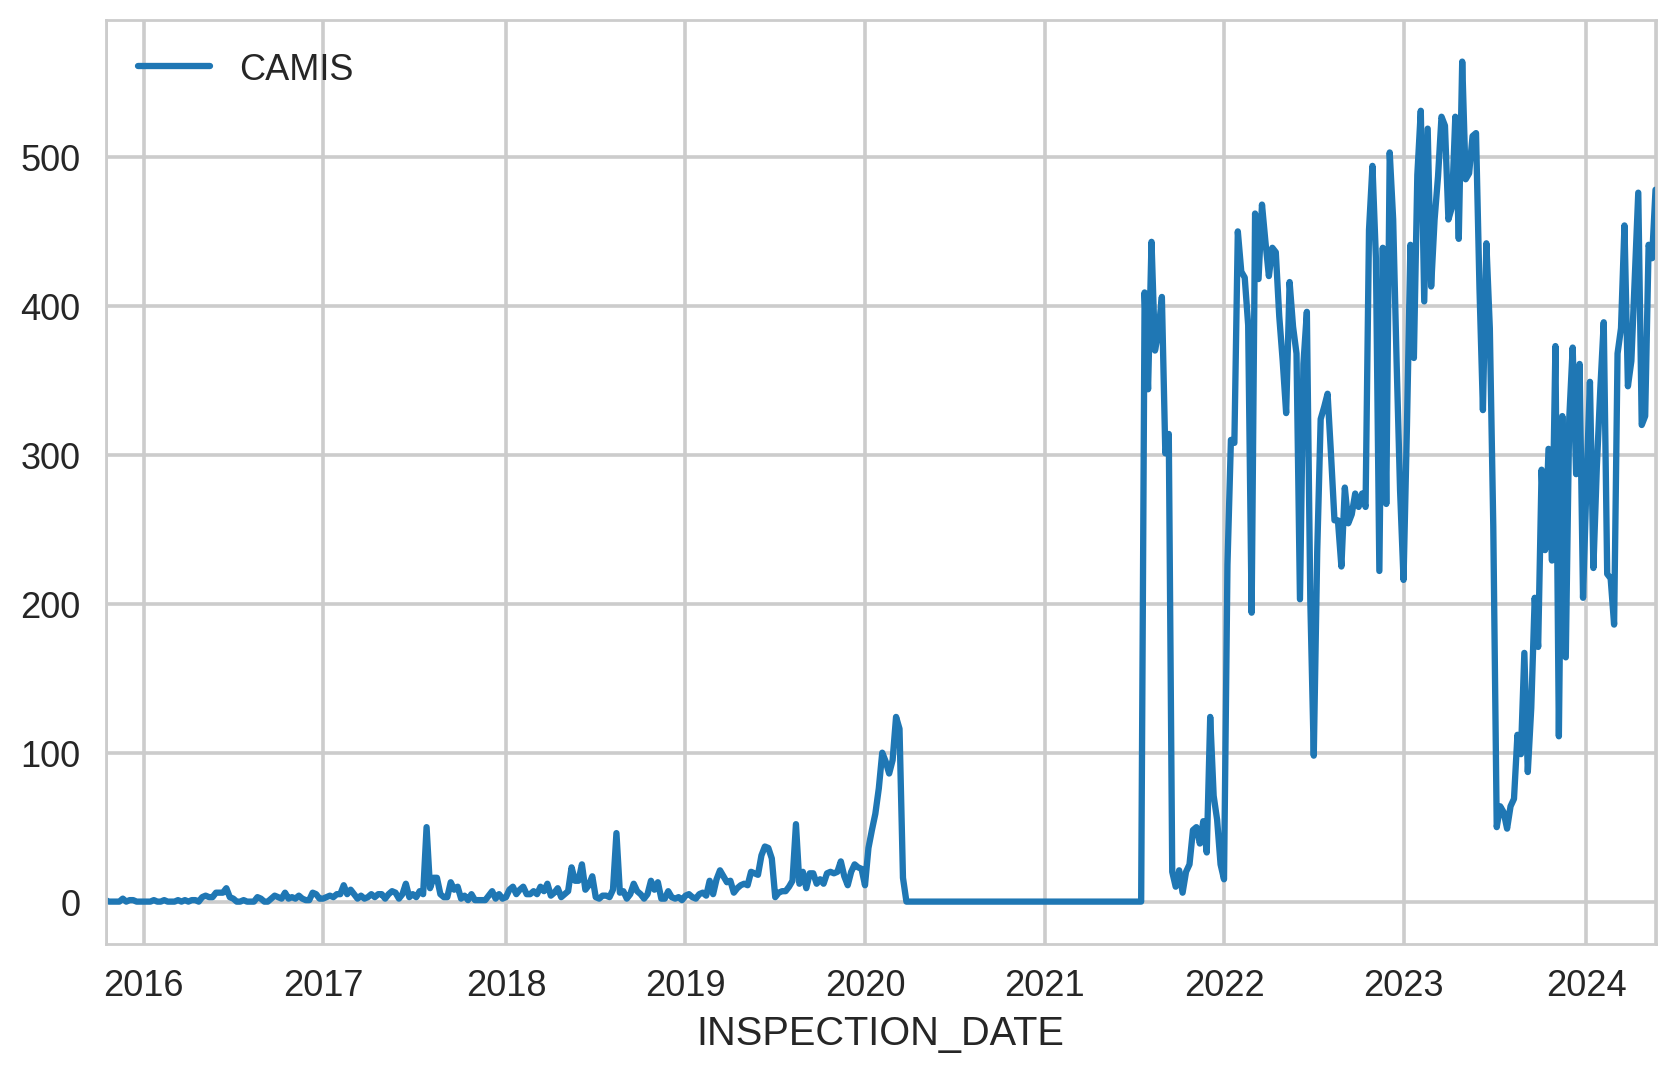

In [16]:
# Plot the average number of inspections, over 7-day periods
pivot.resample("1W").sum().plot()

<ipython-input-17-3fb2b5072ffa>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pivot.resample("1M").sum().plot()


<Axes: xlabel='INSPECTION_DATE'>

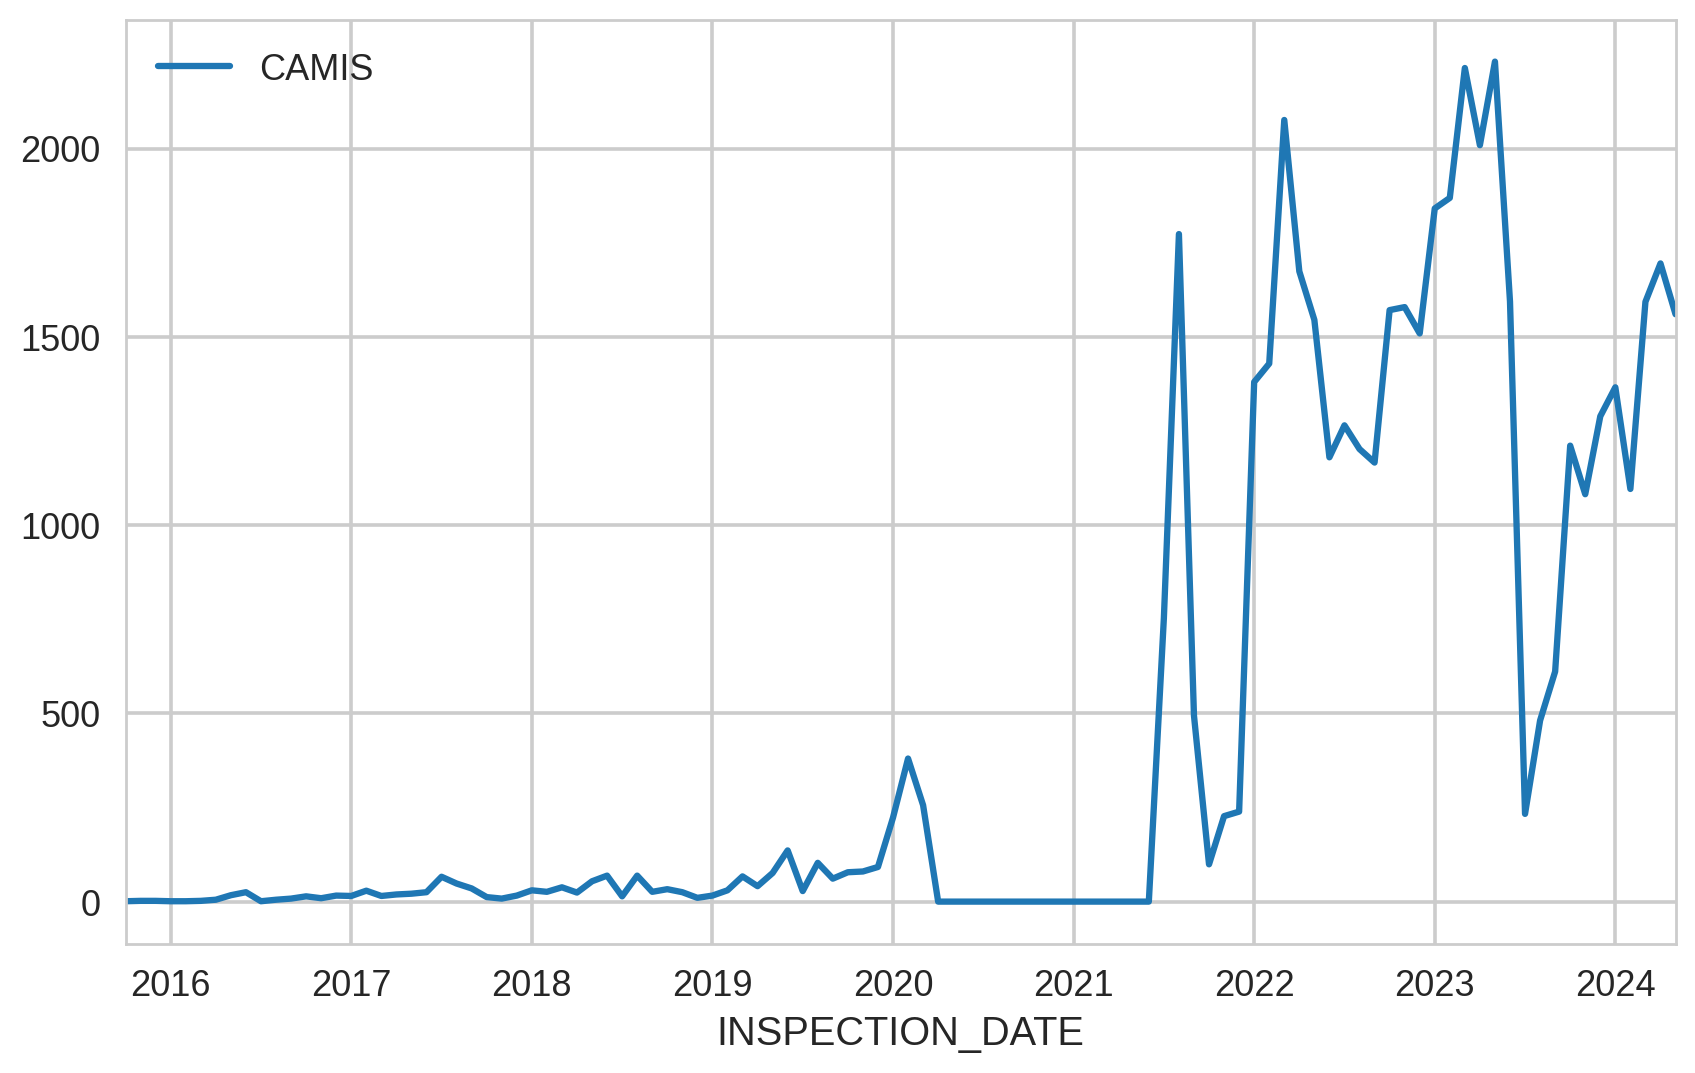

In [17]:
#plot over 1 month period
pivot.resample("1M").sum().plot()

Text(0.5, 1.0, 'Analysis of Number of Inspections over Time')

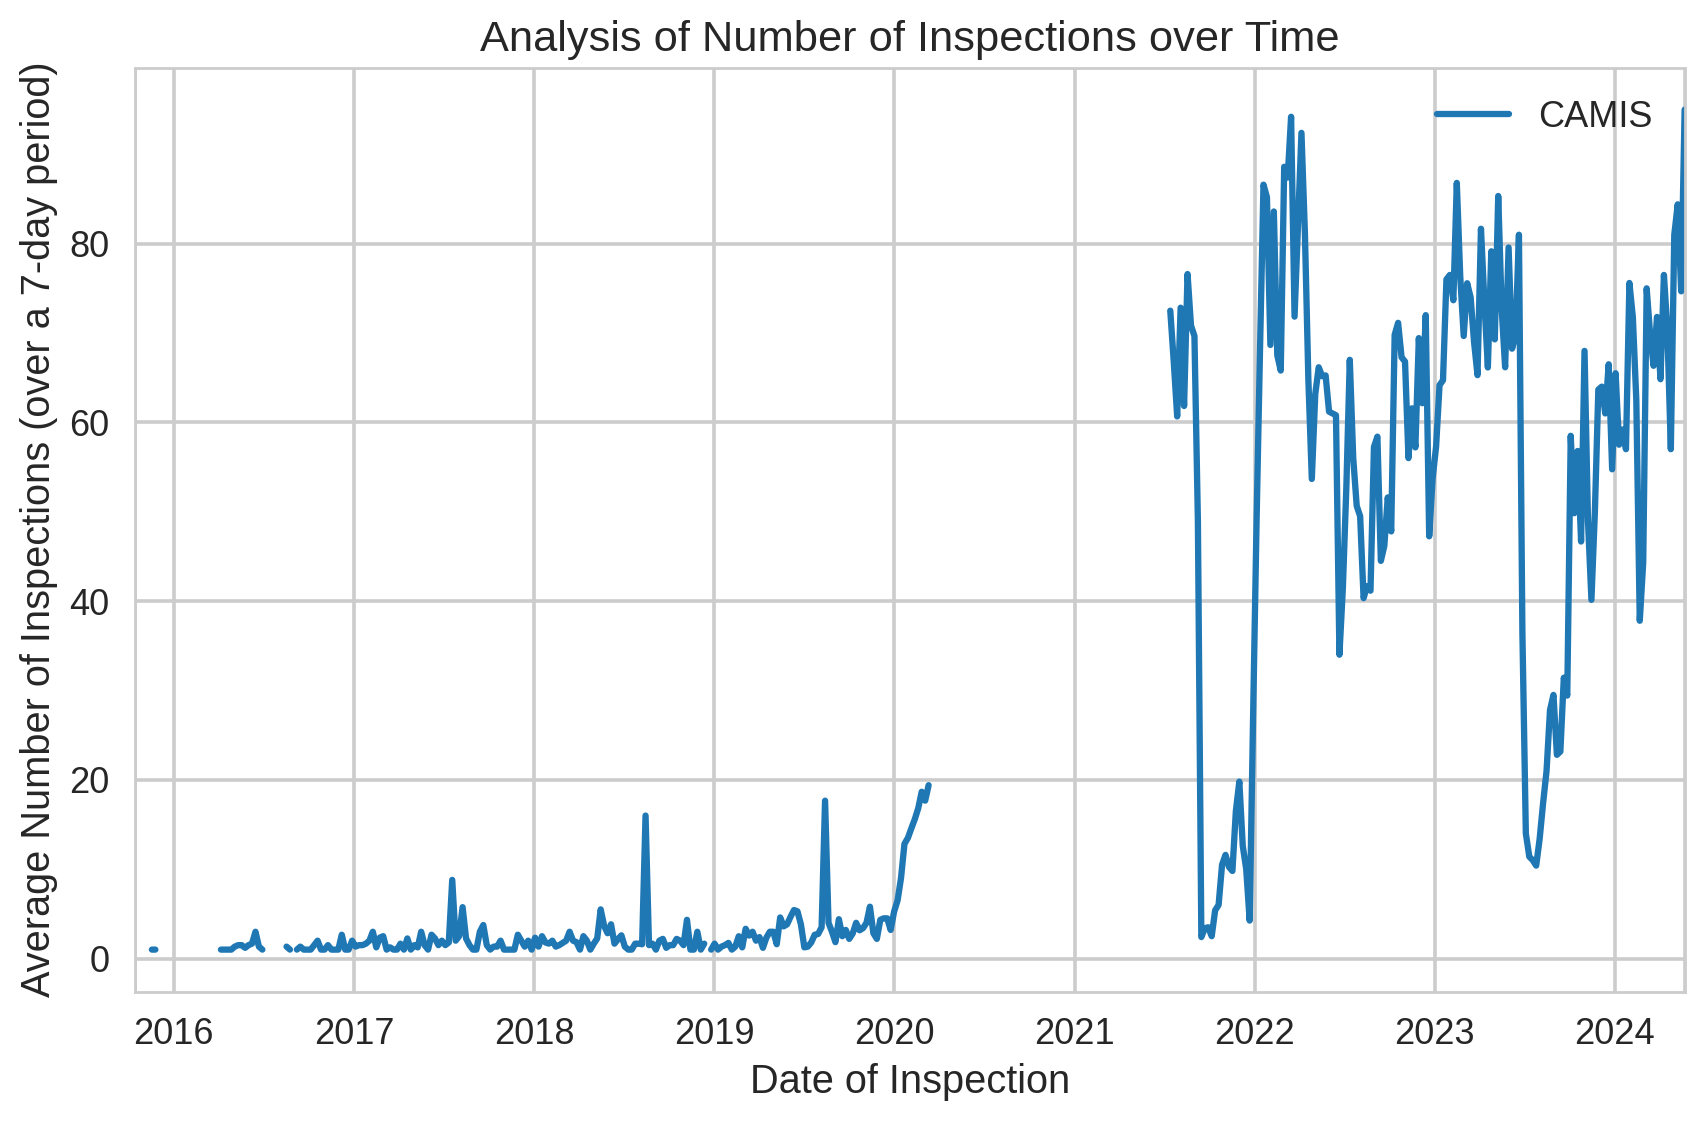

In [18]:
plot = pivot.resample("7D").mean().plot()
plot.set_xlabel("Date of Inspection")
plot.set_ylabel("Average Number of Inspections (over a 7-day period)")
plot.set_title("Analysis of Number of Inspections over Time")

In [19]:
#Pivot multiple variables
pivot2 = pd.pivot_table(
    data=inspections,  #
    index="GRADE",
    columns="BORO",
    values="CAMIS",
    aggfunc="count"
)
pivot2


BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island
GRADE,,,,,
A,2437,7781,11029,6408,1211
B,286,677,844,584,110
C,78,271,319,226,21


<Axes: xlabel='GRADE'>

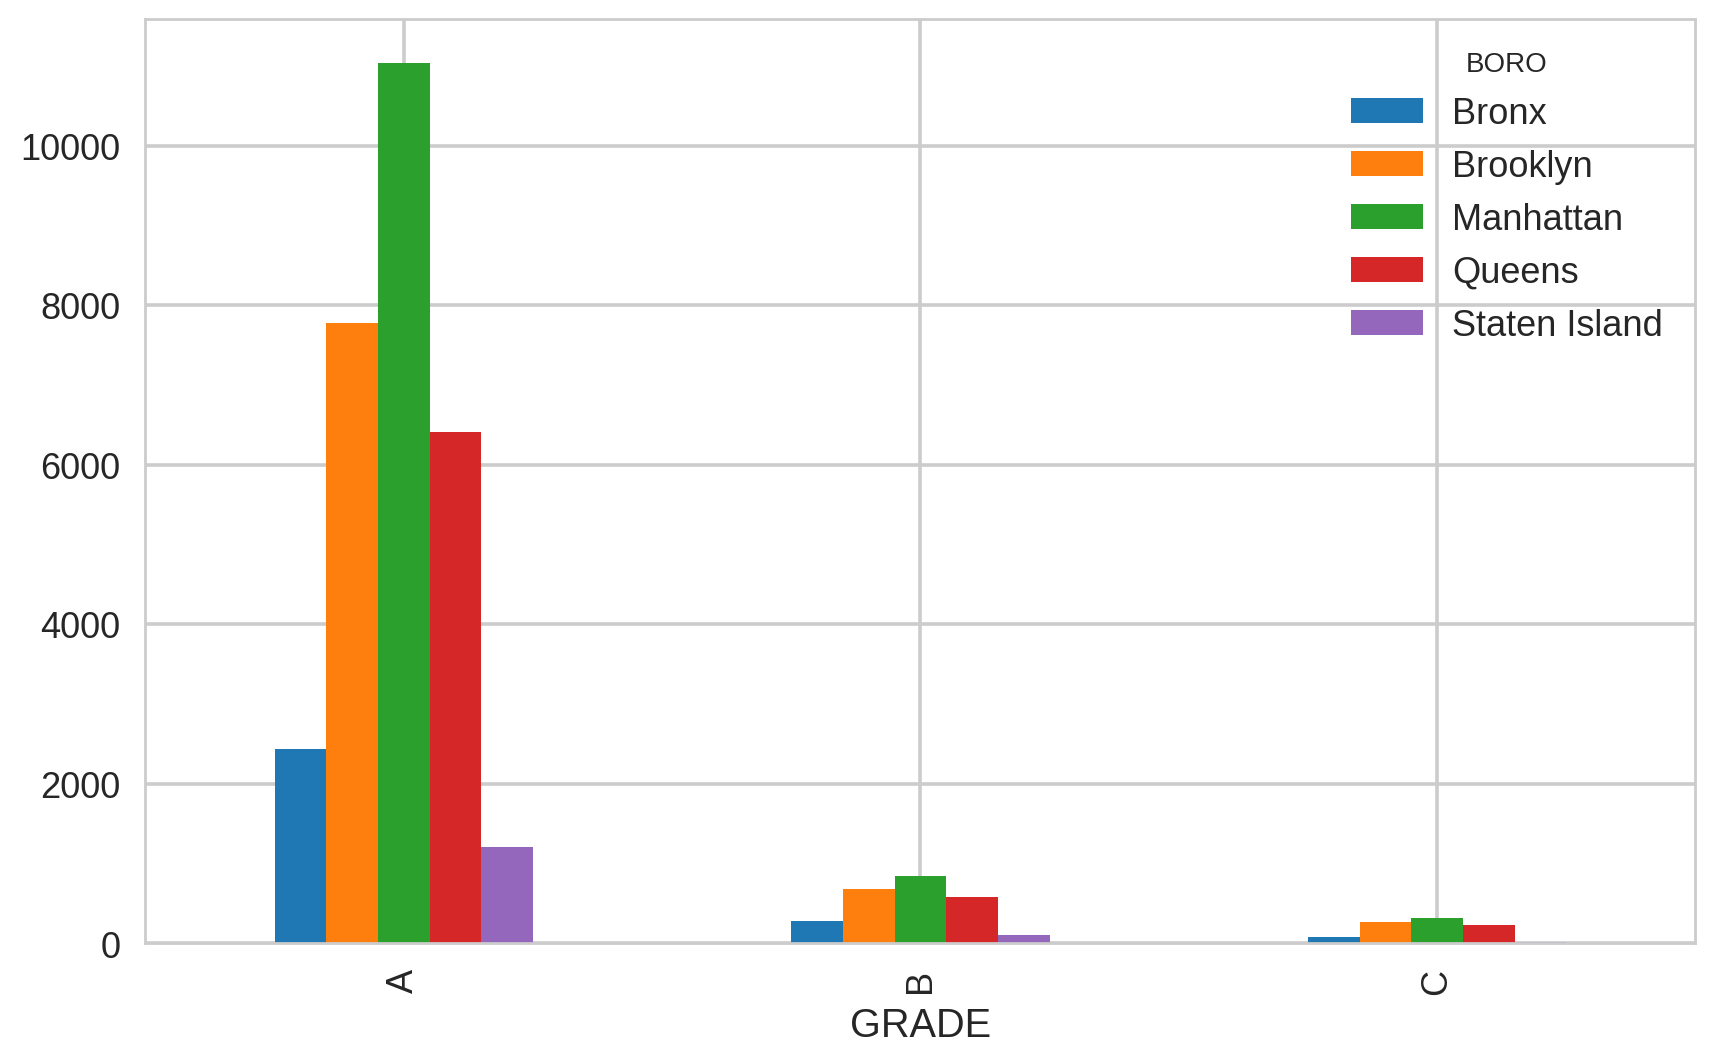

In [20]:
# by default index become x axis
pivot2.plot(kind='bar')

In [21]:
# We break down by BORO and GRADE, and also calculate
# inspections scores
pivot_advanced = pd.pivot_table(
    data=inspections,  #
    index="INSPECTION_DATE",
    columns=["BORO", "GRADE"],
    values="SCORE",
    aggfunc=["mean", "std"],
)
pivot_advanced

mean                                                \
BORO                 Bronx           Brooklyn          Manhattan           
GRADE                    A   B   C          A   B   C          A   B   C   
INSPECTION_DATE                                                            
2015-10-14             NaN NaN NaN        NaN NaN NaN   5.000000 NaN NaN   
2015-11-19             NaN NaN NaN        NaN NaN NaN  12.000000 NaN NaN   
2015-11-20             NaN NaN NaN        NaN NaN NaN  10.000000 NaN NaN   
2015-12-01             NaN NaN NaN        NaN NaN NaN   4.000000 NaN NaN   
2016-01-21             NaN NaN NaN   6.000000 NaN NaN        NaN NaN NaN   
...                    ...  ..  ..        ...  ..  ..        ...  ..  ..   
2024-05-20        7.250000 NaN NaN   8.200000 NaN NaN  10.000000 NaN NaN   
2024-05-21       11.166667 NaN NaN   8.125000 NaN NaN   7.677419 NaN NaN   
2024-05-22        8.750000 NaN NaN  10.230769 NaN NaN   8.346154 NaN NaN   
2024-05-23        8.000000 NaN NaN   7.947368 NaN NaN   9.565217 NaN NaN   
2024-05-24        8.500000 NaN NaN   9.200000 NaN NaN   8.444444 NaN NaN   

                            ...      std                                      \
BORO                Queens  ... Brooklyn Manhattan            Queens           
GRADE                    A  ...        C         A   B   C         A   B   C   
INSPECTION_DATE             ...                                                
2015-10-14             NaN  ...      NaN       NaN NaN NaN       NaN NaN NaN   
2015-11-19             NaN  ...      NaN       NaN NaN NaN       NaN NaN NaN   
2015-11-20             NaN  ...      NaN       NaN NaN NaN       NaN NaN NaN   
2015-12-01             NaN  ...      NaN       NaN NaN NaN       NaN NaN NaN   
2016-01-21             NaN  ...      NaN       NaN NaN NaN       NaN NaN NaN   
...                    ...  ...      ...       ...  ..  ..       ...  ..  ..   
2024-05-20        9.052632  ...      NaN  2.529822 NaN NaN  3.487656 NaN NaN   
2024-05-21       11.000000  ...      NaN  4.052876 NaN NaN  1.414214 NaN NaN   
2024-05-22        7.800000  ...      NaN  3.588229 NaN NaN  4.894441 NaN NaN   
2024-05-23       10.166667  ...      NaN  3.787852 NaN NaN  3.459725 NaN NaN   
2024-05-24        7.666667  ...      NaN  4.126473 NaN NaN  5.361903 NaN NaN   

                                       
BORO            Staten Island          
GRADE                       A   B   C  
INSPECTION_DATE                        
2015-10-14                NaN NaN NaN  
2015-11-19                NaN NaN NaN  
2015-11-20                NaN NaN NaN  
2015-12-01                NaN NaN NaN  
2016-01-21                NaN NaN NaN  
...                       ...  ..  ..  
2024-05-20           4.163332 NaN NaN  
2024-05-21                NaN NaN NaN  
2024-05-22           7.778175 NaN NaN  
2024-05-23           3.593976 NaN NaN  
2024-05-24           2.872281 NaN NaN  

[1408 rows x 30 columns]

In [22]:
# Take the total number of inspections (unique and non-unique)
agg = pivot_advanced.resample("1M").mean()

# Show the last 5 entries and show the transpose (.T)
agg.tail().T

<ipython-input-22-a62a76a1777e>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = pivot_advanced.resample("1M").mean()


INSPECTION_DATE           2024-01-31  2024-02-29  2024-03-31  2024-04-30  \
     BORO          GRADE                                                   
mean Bronx         A        9.731944    9.618519    9.960873    9.939773   
                   B             NaN   22.285714   21.261905   24.500000   
                   C       29.000000   37.800000   31.000000   43.250000   
     Brooklyn      A        8.857733    8.876359    9.248848    9.283321   
                   B       22.714286   21.523333   21.975000   22.102564   
                   C       42.666667   37.222222   43.062500   31.833333   
     Manhattan     A        9.965173    9.712978    9.496997    9.400798   
                   B       22.357143   21.066667   22.474510   22.218182   
                   C       50.666667   41.527778   44.854167   33.916667   
     Queens        A        9.192981    9.749933   10.028970    9.326833   
                   B       22.142857   23.666667   21.318627   22.954545   
                   C       37.666667   39.400000   41.772727   36.916667   
     Staten Island A        9.469608    8.607143   10.280702    9.740833   
                   B             NaN   24.000000   21.928571   25.000000   
                   C             NaN   43.000000   34.000000         NaN   
std  Bronx         A        2.634934    2.420346    2.753635    2.591822   
                   B             NaN         NaN    3.203747    0.000000   
                   C             NaN         NaN         NaN         NaN   
     Brooklyn      A        3.651394    3.424812    3.342880    3.364280   
                   B        7.071068    3.594940    3.419180    2.980055   
                   C             NaN    9.899495   10.401811    2.121320   
     Manhattan     A        3.102645    2.929992    3.120410    3.157873   
                   B        4.949747    3.733154    3.387563    2.799511   
                   C       11.532563    5.155591   14.832378    0.353553   
     Queens        A        3.212035    2.949398    3.089839    3.202831   
                   B        5.656854    2.267767    3.989975    3.712311   
                   C             NaN         NaN    8.720984    0.707107   
     Staten Island A        2.714102    2.825454    2.565435    2.673698   
                   B             NaN         NaN    1.649916    0.000000   
                   C             NaN         NaN         NaN         NaN   

INSPECTION_DATE           2024-05-31  
     BORO          GRADE              
mean Bronx         A        8.284524  
                   B             NaN  
                   C             NaN  
     Brooklyn      A        8.842086  
                   B       23.333333  
                   C       31.000000  
     Manhattan     A        8.999405  
                   B             NaN  
                   C       34.000000  
     Queens        A        9.415970  
                   B       19.666667  
                   C       57.000000  
     Staten Island A        8.933333  
                   B             NaN  
                   C             NaN  
std  Bronx         A        3.430053  
                   B             NaN  
                   C             NaN  
     Brooklyn      A        3.549210  
                   B             NaN  
                   C             NaN  
     Manhattan     A        3.381886  
                   B             NaN  
                   C             NaN  
     Queens        A        3.536084  
                   B             NaN  
                   C             NaN  
     Staten Island A        3.298450  
                   B             NaN  
                   C             NaN

##Normalization, with application to Pivot Tables (and beyond)


In [23]:
# Let's say that we want to normalize the values
# to account for the different number of inspections
# in each borough
pivot2.sum()

,0
BORO,
Bronx,2801
Brooklyn,8729
Manhattan,12192
Queens,7218
Staten Island,1342


In [24]:
# This command normalizes each column, by dividing with its sum:
pivot2 / pivot2.sum()

BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island
GRADE,,,,,
A,0.870046,0.891396,0.904610,0.887781,0.902385
B,0.102106,0.077558,0.069226,0.080909,0.081967
C,0.027847,0.031046,0.026165,0.031311,0.015648


<Axes: xlabel='GRADE'>

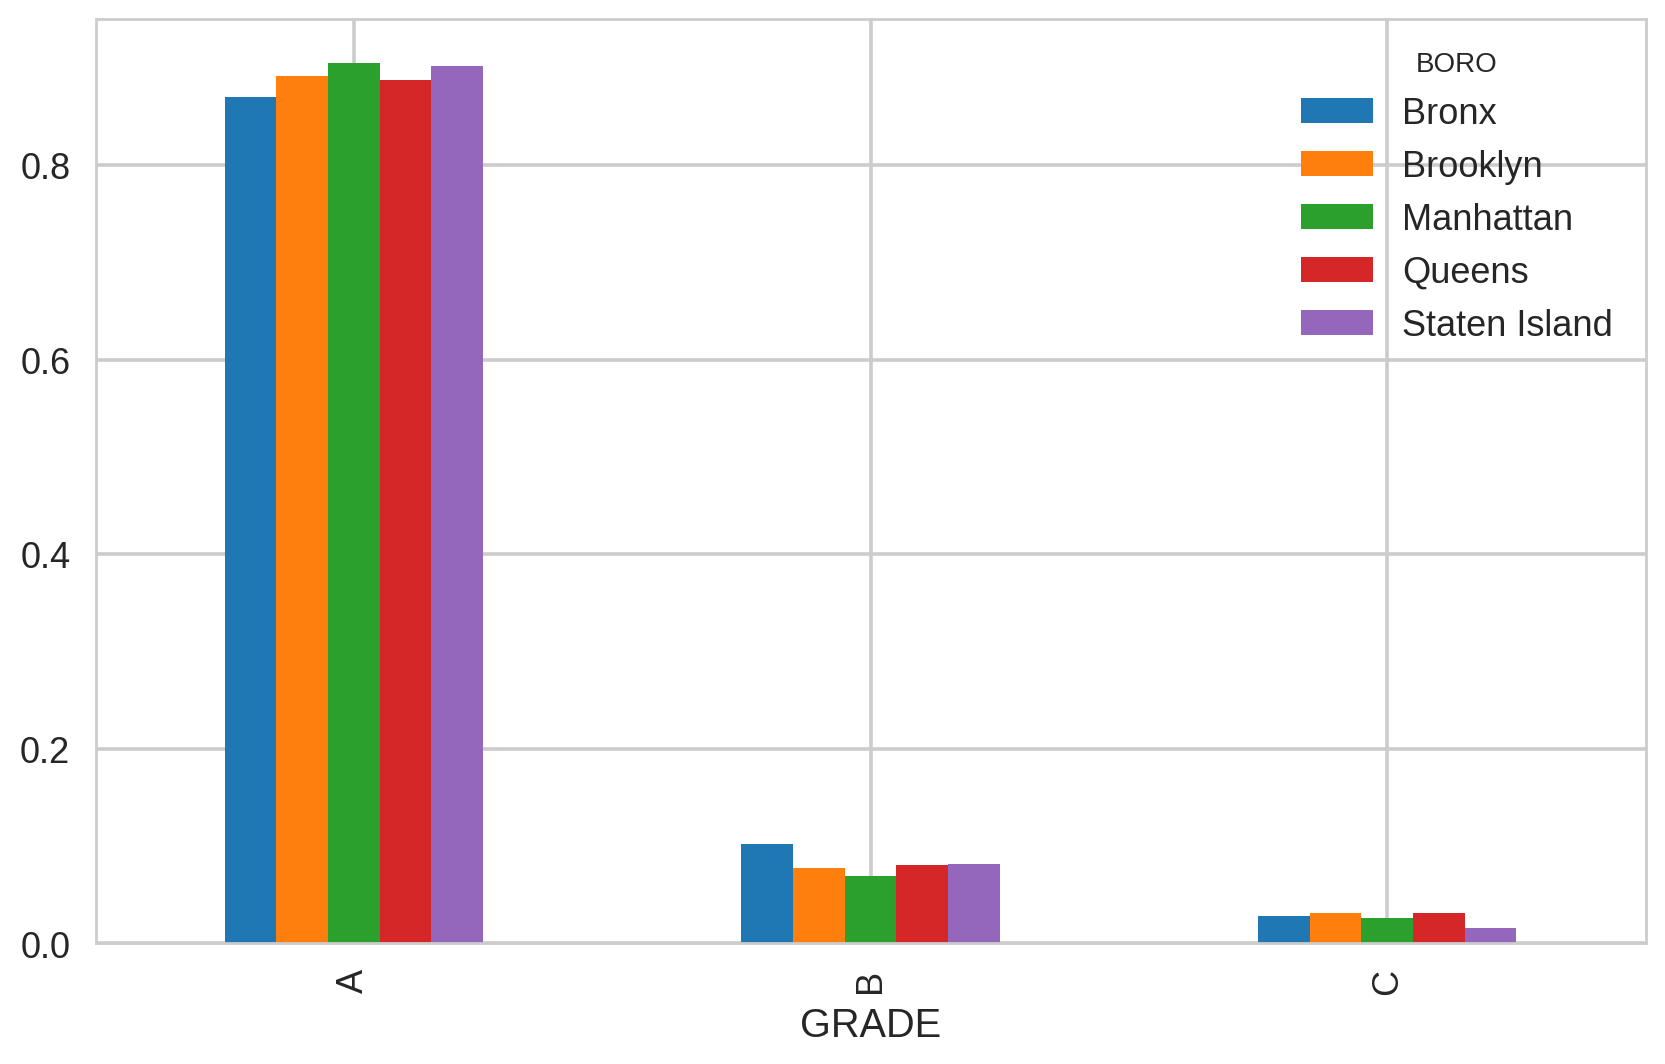

In [25]:
normalized = pivot2 / pivot2.sum()

#Percent of insp per borough with a given grade
normalized.plot(kind='bar')

##Normalize and Transponse

In [26]:
# transpose the dataframe
pivot2.T

GRADE,A,B,C
BORO,,,
Bronx,2437,286,78
Brooklyn,7781,677,271
Manhattan,11029,844,319
Queens,6408,584,226
Staten Island,1211,110,21


<Axes: ylabel='BORO'>

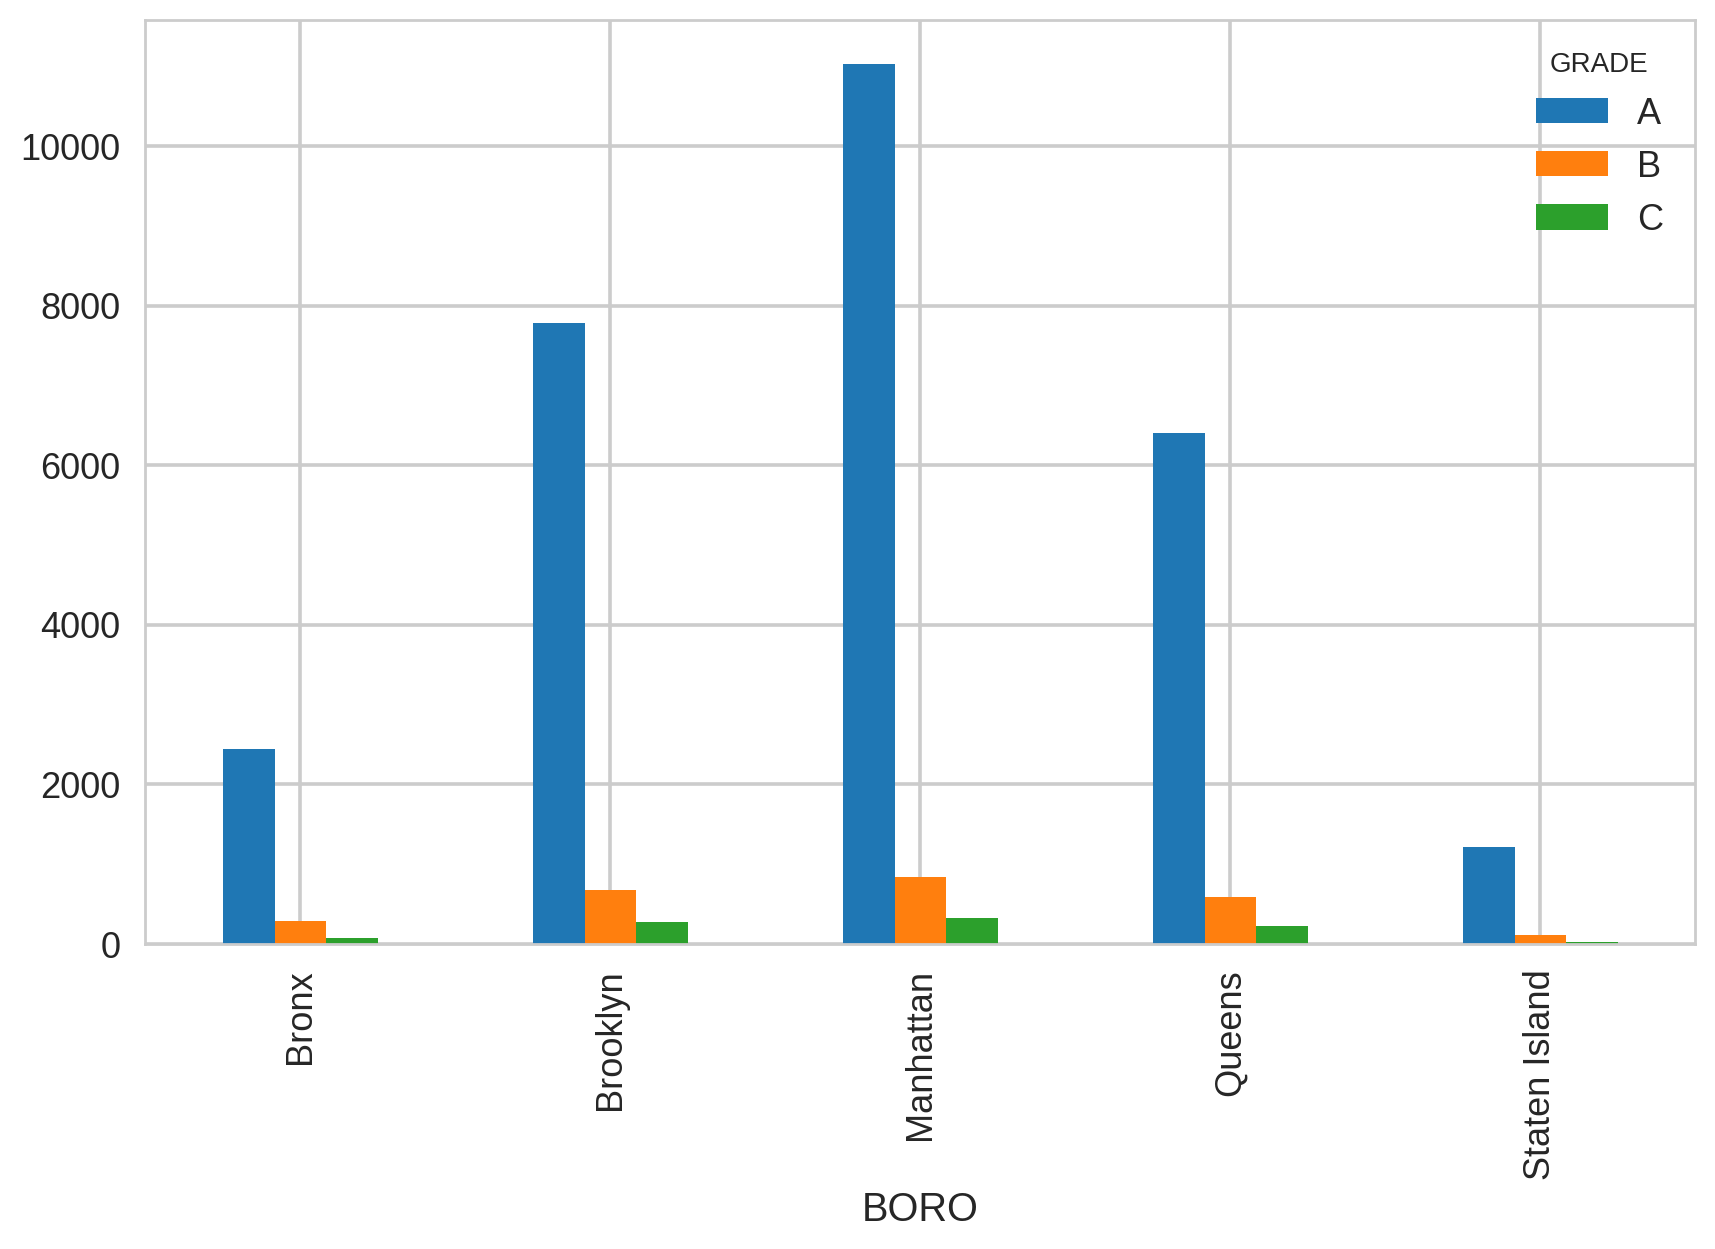

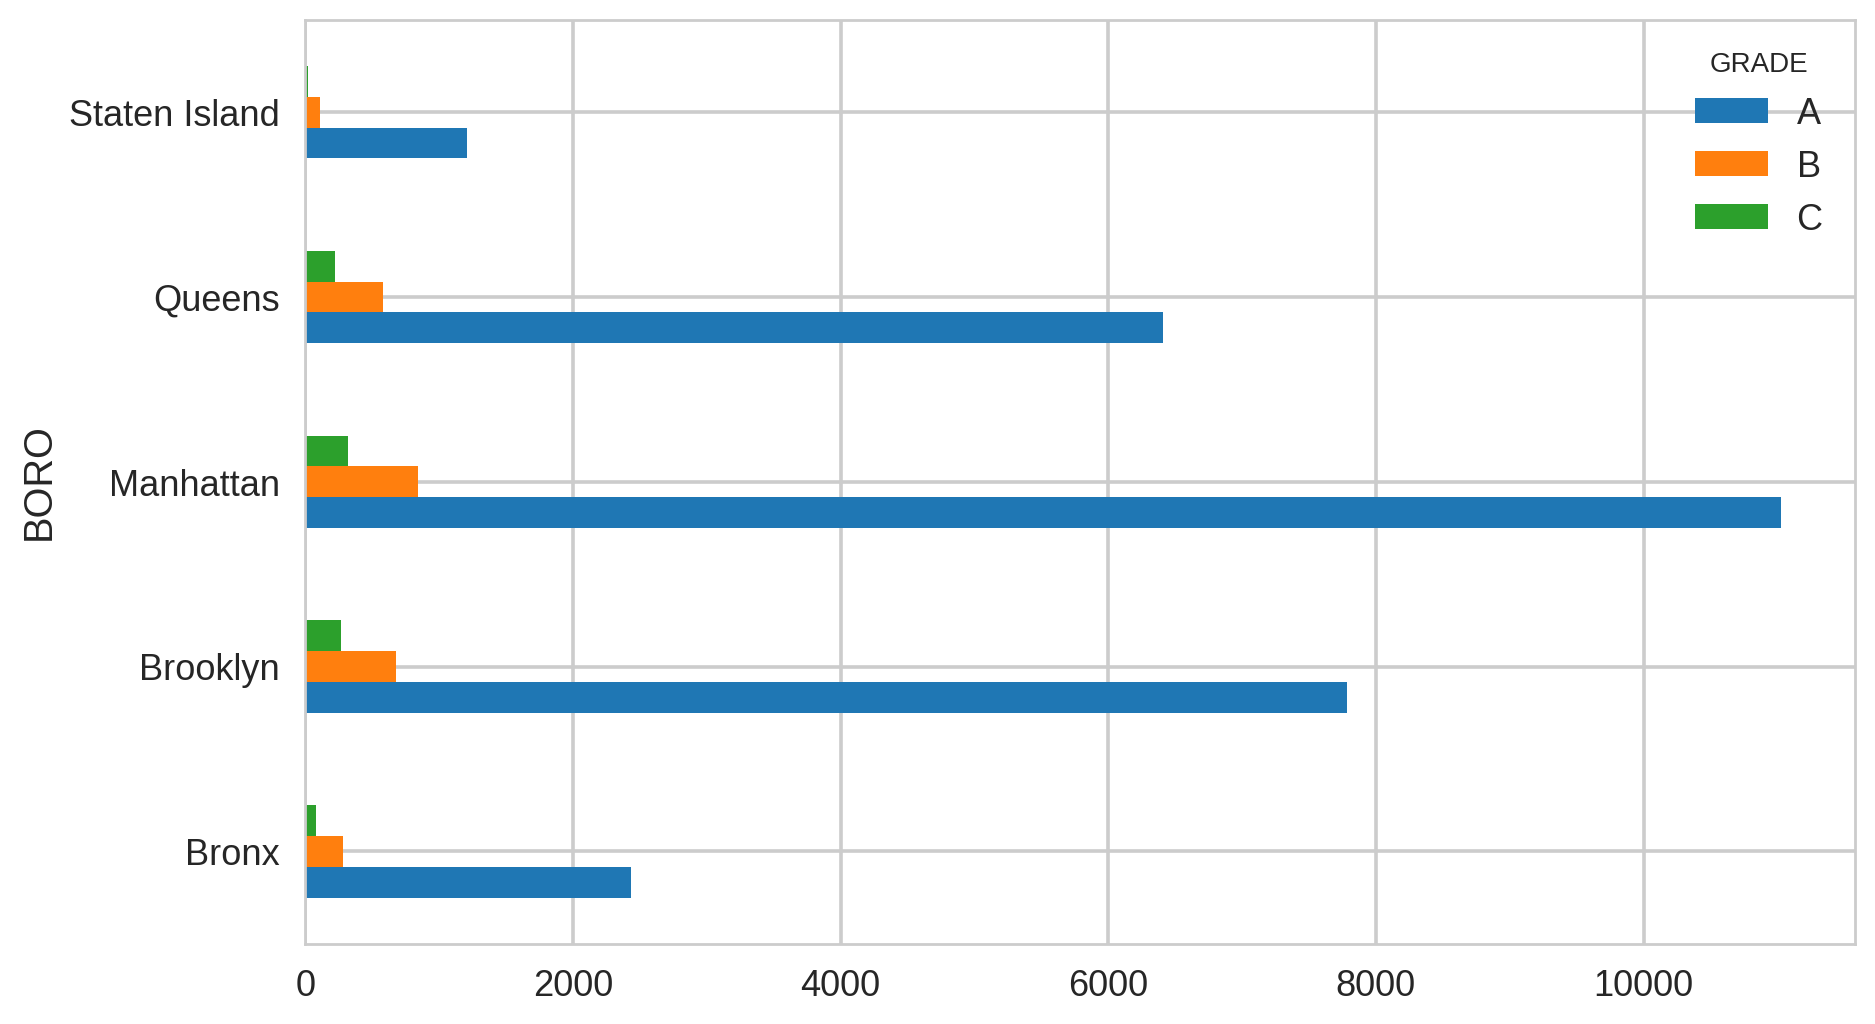

In [27]:
#transpose to use the borough as the x axis
pivot2.T.plot(kind='bar')

#use barh to see better
pivot2.T.plot(kind='barh')

In [28]:
#combine into one bar
# see thepivot2.T.plot(kind='barh', stacked = True)

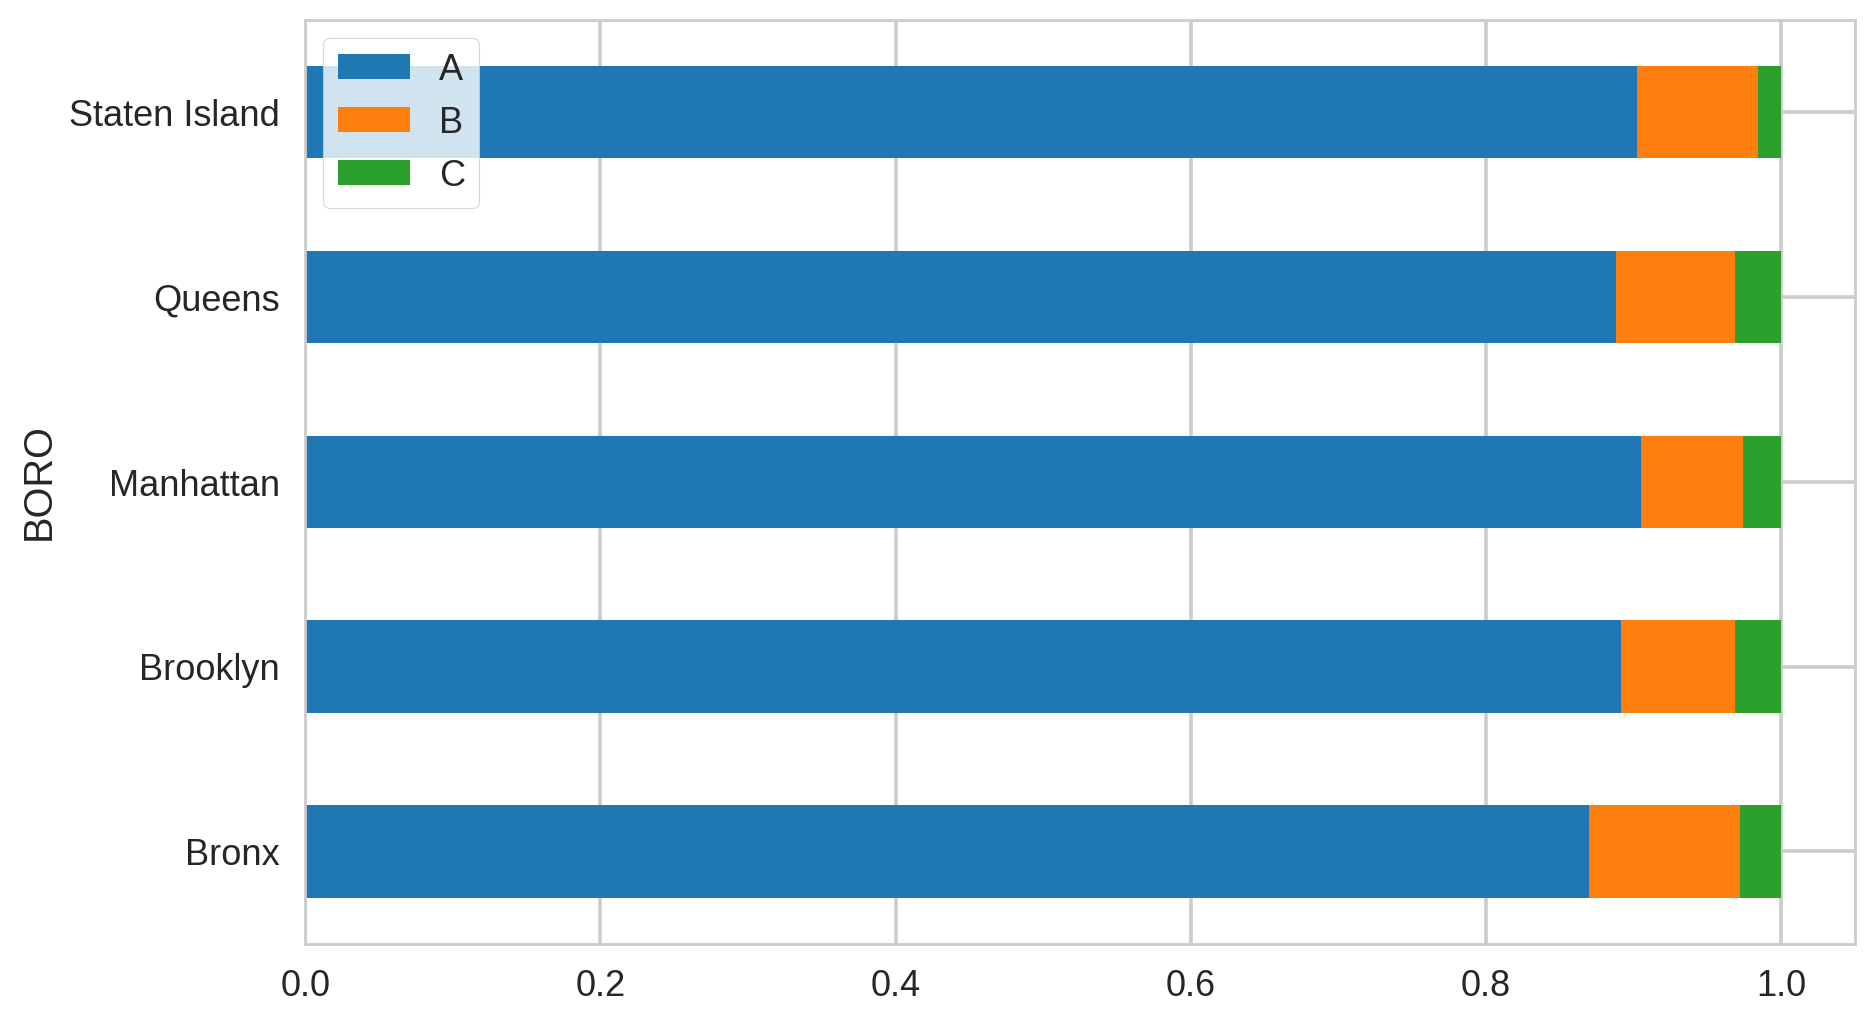

In [29]:
#see the comparison of the boros by normalized distribution
normalized.T.plot(kind='barh', stacked = True).legend(frameon=True)

In [30]:
popular = (
    pd.pivot_table(
    data=inspections,
    index="CUISINE_DESCRIPTION",  # cuisines are the rows
    values="SCORE",  # we analyze the SCORE
    aggfunc=["mean","count"]  # compute the average SCORE
    )
    .sort_values(by=('count','SCORE'), ascending=False) # sort according to the popularity (count) of each cuisine
    .head(4) # keep the top-4 most popular cuisined
    .index # keep the names of the cuisines, which appear in the index
    .values # and retrieve their values
)


In [31]:
#comp avg inspection score by cuisine
pop = (
    pd.pivot_table(
        data=inspections,
        index="CUISINE_DESCRIPTION", #cuisines are the rows
        values="SCORE",       #we analyze the score
        aggfunc=["mean","count"]       # compute the avg score
    )
    .sort_values(by =('count', 'SCORE'), ascending = False) #sort according to the popularity (count) of each cuisine
    .head(10) #keep the to 10 pop cuisine
    .index #keep the names of the cuisines, which appear in the index
    .values #and retrieve their values
)

<ipython-input-32-c8d5f239f9ae>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("3M").mean() # convert granularity to monthly and taking average score


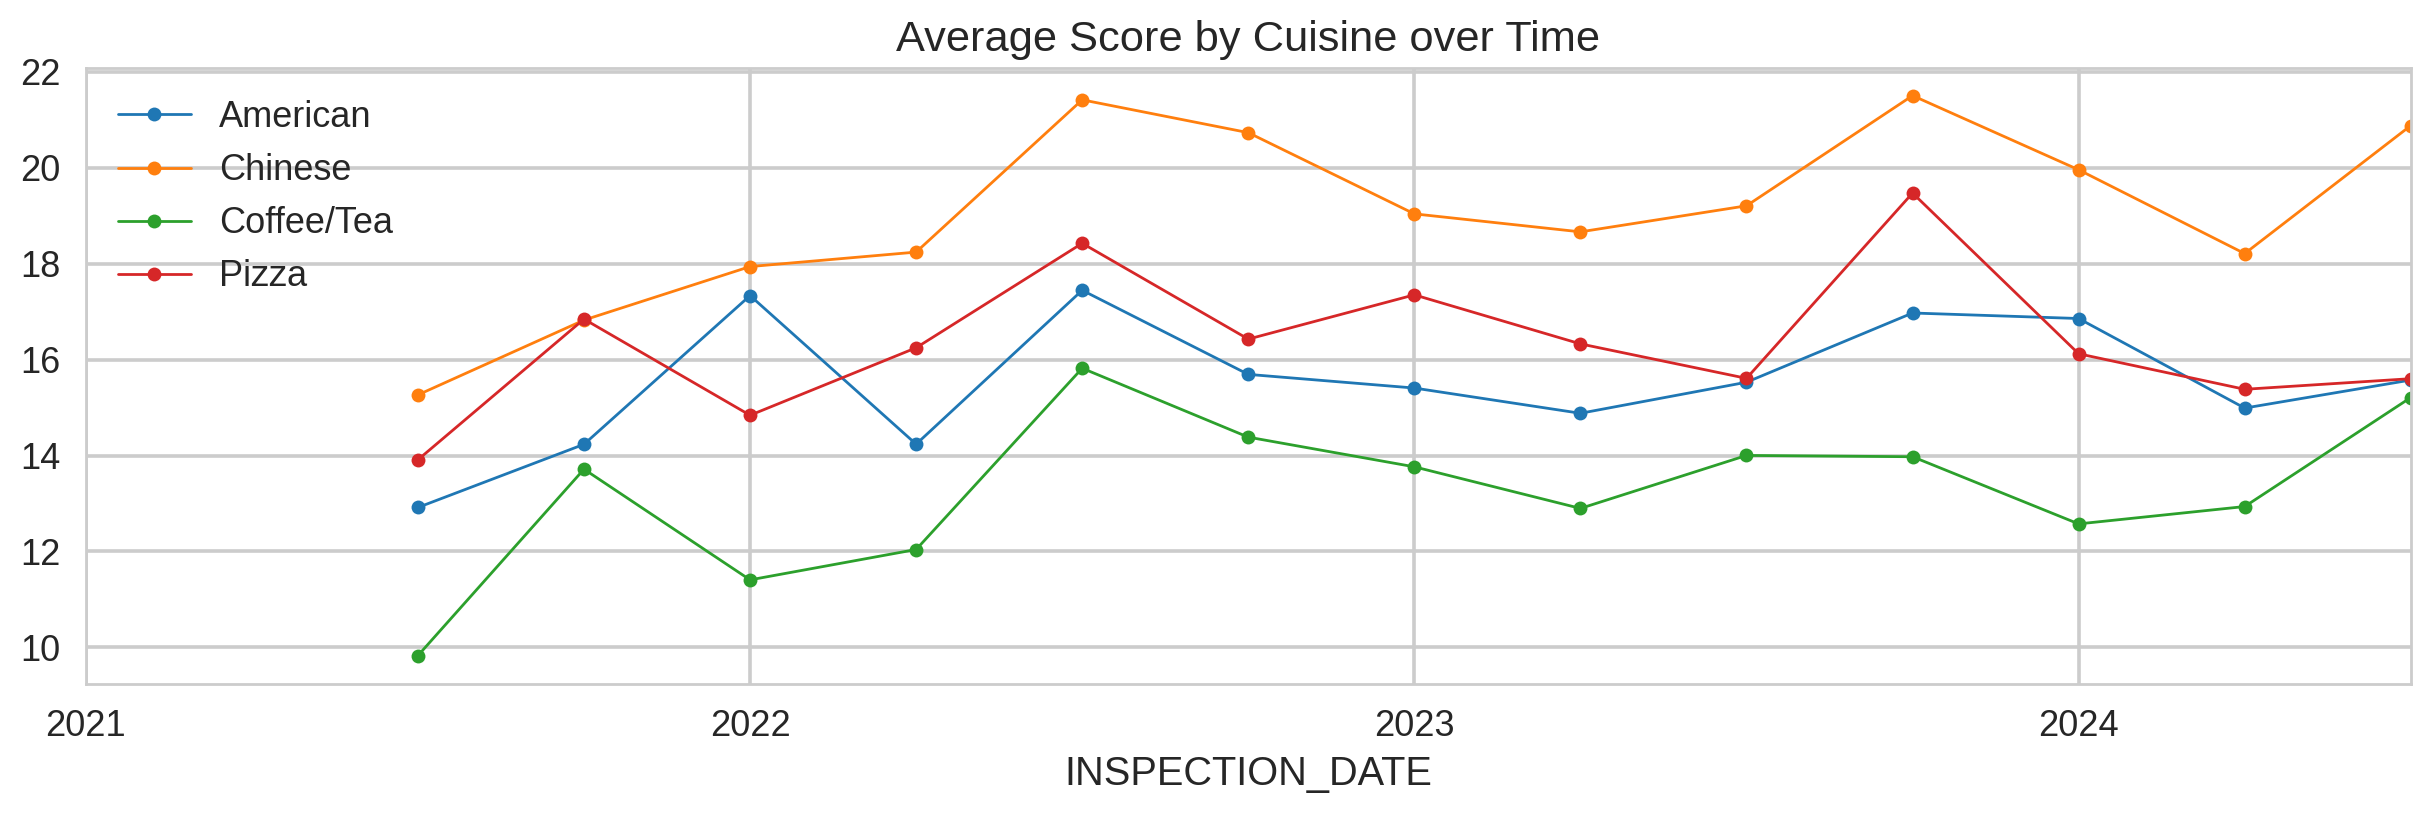

In [32]:
# Select 3 columns (american, frenchn, chinese), compute the average score for a month
# and plot the results
(
    pd.pivot_table(
        data=inspections,
        index="INSPECTION_DATE",  # dates are the rows
        columns="CUISINE_DESCRIPTION",  # cuisines are the columns
        values="SCORE",  # we analyze the SCORE
        aggfunc="mean"  # compute the average SCORE
    )
    .filter(pop) # keep only the popular cuisines
    .resample("3M").mean() # convert granularity to monthly and taking average score
    .reset_index() # we take the INSPECTION_DATE out of the index to query and limit the x-axis
    .query("INSPECTION_DATE > '2021-01-01' ") # keep only dates after 2001
    .plot(
        kind = 'line',
        marker = 'o', markersize = 5, linewidth = 1,
        x = "INSPECTION_DATE",
        y = popular,
        figsize=(15, 4),
        title = "Average Score by Cuisine over Time"
      ).legend(
          loc='upper left',
      )
)

##defining new columns with assign() and apply()

In [33]:
''' Create a define function that takes as input dataframe
and returns a new column '''

#function combines street/building/boro/zipcode

def comb_address(df):
  return(df.BUILDING + ' ' + df.STREET + ', ' + df.BORO + ', NY ' + df.ZIPCODE).str.upper()


# create a function to compute the distance in mi from NYU
# given the lat/lon of the other locations

def distance(df):
  NYU_lon = -73.9962293
  NYU_lat = 40.7291527
  #calc the ythagorean theorem
  #norm values "0.0146" and "0.0196"
  #use to convert lat/lon to miles
  distance = ((df['LATITUDE']-NYU_lat)/0.0146)**2 + ((df['LONGITUDE']-NYU_lon)/0.0196)**2
  return np.sqrt(distance)

In [34]:
#use assign funtion to create two new columns
# using the logic in the funtion above

(
    restaurants
    .assign(
        distance_from_nyu = distance,
        address = comb_address
    )
    .filter(items = ['DBA', 'address', 'distance_from_nyu'])
)


,DBA,address,distance_from_nyu
0,MORRIS PARK BAKE SHOP,"1007 MORRIS PARK AVENUE, BRONX, NY 10462",10.847772
1,WENDY'S,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",4.873268
2,DJ REYNOLDS PUB AND RESTAURANT,"351 WEST 57 STREET, MANHATTAN, NY 10019",2.682781
3,RIVIERA CATERERS,"2780 STILLWELL AVENUE, BROOKLYN, NY 11224",10.248173
4,WILKEN'S FINE FOOD,"7114 AVENUE U, BROOKLYN, NY 11234",8.747387
...,...,...,...
19737,Chen Express,"223 EAST 14 STREET, MANHATTAN, NY 10003",0.562001
19738,LA BOMBONIERA,"1378 LEXINGTON AVENUE, MANHATTAN, NY 10128",4.265976
19739,PRET,"1 ASTOR PLACE, MANHATTAN, NY 10003",0.194050
19740,TAQUERIA EL TANQUE,"260 BROOK AVENUE, BRONX, NY 10454",6.688151


In [35]:
# delete duplicates

(
    restaurants
    .assign(
        distance_from_nyu = distance,
        address = comb_address
    )
    .drop_duplicates()
    .filter(items = ['DBA', 'address', 'distance_from_nyu'])
    .query('distance_from_nyu > 0') # eliminates NaN values from distance from NYU
    .sort_values('distance_from_nyu')
    .head(10)
)

,DBA,address,distance_from_nyu
14631,STARBUCKS,"45 WEST 4 STREET, MANHATTAN, NY 10012",0.017318
2592,THINK COFFEE,"248 MERCER STREET, MANHATTAN, NY 10012",0.069250
17616,SPRING CAFE ASPEN,"14 WEST 4 STREET, MANHATTAN, NY 10012",0.074573
14626,KIMMEL MARKET PLACE @ NYU( 3rd Floor),"60 WASHINGTON SQUARE SOUTH, MANHATTAN, NY 10012",0.103111
14632,PEET'S COFFEE @ NYU,"60 WASHINGTON SQUARE SOUTH, MANHATTAN, NY 10012",0.103111
19014,CHIHIRO TEA,"552 LAGUARDIA PLACE, MANHATTAN, NY 10012",0.107056
5079,MILLE-FEUILLE BAKERY CAFE,"552 LAGUARDIA PLACE, MANHATTAN, NY 10012",0.107056
1641,NEGRIL,"70 WEST 3 STREET, MANHATTAN, NY 10012",0.108293
15293,SPICY MOON VEGETARIAN SZECHUAN,"68 WEST 3 STREET, MANHATTAN, NY 10012",0.108293
10669,DO COOKIE DOUGH CONFECTIONS,"550 LAGUARDIA PLACE, MANHATTAN, NY 10012",0.108375


###Using apply()


In [48]:
#apply allows us to pass the funtion on every row

!sudo pip3 install -q -U geopy

from geopy import distance

''' more accuratge distance calc
returns distance in mi. We cannot pass a df
to the function only individual values '''
def distance_from_nyu_geo(row):
  nyu_lon = -73.9962293
  nyu_lat = 40.7291527
  nyu = (nyu_lat, nyu_lon)
  rest = (row.LATITUDE, row.LONGITUDE)
  #if pd.isnull(row.LATITUDE) or pd.isnull(row.LONGITUDE):
  #  return None
  return distance.distance(nyu, rest).miles

In [39]:
#create smaller version (name,address,lon,lat)
rest_names_loc = (
    restaurants
    .assign(
        address = comb_address
    )
    .filter(items = ['CAMIS', 'DBA', 'address', 'LATITUDE', 'LONGITUDE'])
    .query(' LONGITUDE ==LONGITUDE ') #idiomatic expression for saying IS NOT NULL
    .query(' LATITUDE ==LATITUDE ')  #idiomatice expression for saying IS NOT NULL
    .drop_duplicates()
)

rest_names_loc

,CAMIS,DBA,address,LATITUDE,LONGITUDE
0,30075445,MORRIS PARK BAKE SHOP,"1007 MORRIS PARK AVENUE, BRONX, NY 10462",40.8482,-73.8560
1,30112340,WENDY'S,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",40.6627,-73.9621
2,30191841,DJ REYNOLDS PUB AND RESTAURANT,"351 WEST 57 STREET, MANHATTAN, NY 10019",40.7673,-73.9843
3,40356018,RIVIERA CATERERS,"2780 STILLWELL AVENUE, BROOKLYN, NY 11224",40.5799,-73.9821
4,40356483,WILKEN'S FINE FOOD,"7114 AVENUE U, BROOKLYN, NY 11234",40.6201,-73.9070
...,...,...,...,...,...
19737,50144964,Chen Express,"223 EAST 14 STREET, MANHATTAN, NY 10003",40.7330,-73.9865
19738,50145448,LA BOMBONIERA,"1378 LEXINGTON AVENUE, MANHATTAN, NY 10128",40.7826,-73.9533
19739,50146152,PRET,"1 ASTOR PLACE, MANHATTAN, NY 10003",40.7300,-73.9926
19740,50146220,TAQUERIA EL TANQUE,"260 BROOK AVENUE, BRONX, NY 10454",40.8080,-73.9189


In [49]:
#apply function distance
#to every row in the dataset
rest_names_loc.apply(distance_from_nyu_geo, axis = 'columns')

,0
0,11.025788
1,4.923254
2,2.705684
3,10.325400
4,8.865529
...,...
19737,0.575580
19738,4.321515
19739,0.199280
19740,6.786673


In [50]:
#create and save into new colums
rest_names_loc['distance_from_nyu'] = rest_names_loc.apply(distance_from_nyu_geo, axis = 'columns')
rest_names_loc

,CAMIS,DBA,address,LATITUDE,LONGITUDE,distance_from_nyu
0,30075445,MORRIS PARK BAKE SHOP,"1007 MORRIS PARK AVENUE, BRONX, NY 10462",40.8482,-73.8560,11.025788
1,30112340,WENDY'S,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",40.6627,-73.9621,4.923254
2,30191841,DJ REYNOLDS PUB AND RESTAURANT,"351 WEST 57 STREET, MANHATTAN, NY 10019",40.7673,-73.9843,2.705684
3,40356018,RIVIERA CATERERS,"2780 STILLWELL AVENUE, BROOKLYN, NY 11224",40.5799,-73.9821,10.325400
4,40356483,WILKEN'S FINE FOOD,"7114 AVENUE U, BROOKLYN, NY 11234",40.6201,-73.9070,8.865529
...,...,...,...,...,...,...
19737,50144964,Chen Express,"223 EAST 14 STREET, MANHATTAN, NY 10003",40.7330,-73.9865,0.575580
19738,50145448,LA BOMBONIERA,"1378 LEXINGTON AVENUE, MANHATTAN, NY 10128",40.7826,-73.9533,4.321515
19739,50146152,PRET,"1 ASTOR PLACE, MANHATTAN, NY 10003",40.7300,-73.9926,0.199280
19740,50146220,TAQUERIA EL TANQUE,"260 BROOK AVENUE, BRONX, NY 10454",40.8080,-73.9189,6.786673


In [51]:
#filter to restaurants that are under .5 miles
(
    rest_names_loc
    .query('distance_from_nyu < 0.5')
    .sort_values('distance_from_nyu')
)

,CAMIS,DBA,address,LATITUDE,LONGITUDE,distance_from_nyu
14631,50093959,STARBUCKS,"45 WEST 4 STREET, MANHATTAN, NY 10012",40.7294,-73.9963,0.017463
2592,41169084,THINK COFFEE,"248 MERCER STREET, MANHATTAN, NY 10012",40.7283,-73.9955,0.070197
17616,50112539,SPRING CAFE ASPEN,"14 WEST 4 STREET, MANHATTAN, NY 10012",40.7287,-73.9949,0.076452
14632,50093960,PEET'S COFFEE @ NYU,"60 WASHINGTON SQUARE SOUTH, MANHATTAN, NY 10012",40.7301,-73.9978,0.105217
14626,50093946,KIMMEL MARKET PLACE @ NYU( 3rd Floor),"60 WASHINGTON SQUARE SOUTH, MANHATTAN, NY 10012",40.7301,-73.9978,0.105217
...,...,...,...,...,...,...
19436,50130517,PLAYA BOWLS,"493 AVENUE OF THE AMERICAS, MANHATTAN, NY 10011",40.7363,-73.9976,0.498402
16857,50107871,CHAMPION PIZZA,"2 WEST 14 STREET, MANHATTAN, NY 10011",40.7362,-73.9941,0.498960
12522,50076340,DUNKIN,"2 WEST 14 STREET, MANHATTAN, NY 10011",40.7362,-73.9941,0.498960
18488,50118694,SUBWAY,"113 EAST 14 STREET, MANHATTAN, NY 10003",40.7342,-73.9894,0.499800
